In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import timeit
import hashlib
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import dump_svmlight_file
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import plotly.graph_objects as go
from tqdm.auto import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)

In [3]:
df7=pd.read_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_AllDestinations__LeftJoin_Amenities_NaHandled_17April.csv')

In [4]:
df8=df7.copy()

# **Data types for amenities and impression columns**

In [5]:
main_columns = {
    'qid': int,
    'point_of_sale': 'O',
    'geo_location_country': 'O',
    'is_mobile': bool,
    'destination_id': 'O',
    'adult_count': int,
    'child_count': int,
    'infant_count': int,
    'room_count': int,
    'sort_type': 'O',
    'length_of_stay': int,
    'booking_window': int,
    'search_day_of_week': 'O',
    'search_hour_of_day': 'O',
    'checkin_day': 'O',
    'checkout_day': 'O'
}

impression_columns = {
    'rank': int,
    'is_travel_ad': bool,
    'review_rating': 'O',
    'review_count': int,
    'star_rating': 'O',
    'is_free_cancellation': bool,
    'is_drr': bool,
    'price_bucket': int,
    'num_clicks': int,
    'is_trans': bool
}

amenities_columns = {
    'prop_id': 'O',
    'AirConditioning': bool,
    'AirportTransfer': bool,
    'Bar': bool,
    'FreeAirportTransportation': bool,
    'FreeBreakfast': bool,
    'FreeParking': bool,
    'FreeWiFi': bool,
    'Gym': bool,
    'HighSpeedInternet': bool,
    'HotTub': bool,
    'LaundryFacility': bool,
    'Parking': bool,
    'PetsAllowed': bool,
    'PrivatePool': bool,
    'SpaServices': bool,
    'SwimmingPool': bool,
    'WasherDryer': bool,
    'WiFi': bool
}

features_engineered= {'user_id': 'O',
 'search_id': 'O',
 'checkin_date': 'datetime',
 'checkout_date': 'datetime',
 'rank_noad': int,
 'number_of_amenities': int}

# Given list of all columns
all_columns = df8.columns.tolist()
# Columns present in any of the dictionaries
present_columns = set(list(main_columns.keys()) + list(impression_columns.keys()) + list(amenities_columns.keys()))

# Columns not present in any of the dictionaries
#features_engineered = {column: None for column in all_columns if column not in present_columns}




In [6]:
for column in tqdm(df8.columns, desc="Converting columns"):
    if column in main_columns:
        df8[column] = df8[column].astype(main_columns[column])
    elif column in impression_columns:
        df8[column] = df8[column].astype(impression_columns[column])
    elif column in amenities_columns:
        df8[column] = df8[column].astype(amenities_columns[column])


Converting columns:   0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
df8.rename(columns={'search_id':'qid'}, inplace=True)

df8['relevance'] = df8['num_clicks'] + 2 * df8['is_trans']
df8.loc[df8['relevance'] > 3, 'relevance'] = 3


# **Columns to be dropped**

Columns to be not dropped are '#' or commented

In [8]:
main_columns_dropped = {
    #'qid': int, # to be dropped after train, test split
    'point_of_sale': 'O',
    'geo_location_country': 'O',
    #'is_mobile': bool,
    #'destination_id': 'O',
    #'adult_count': int,
    #'child_count': int,
    #'infant_count': int,
    #'room_count': int,
    'sort_type': 'O',
    'length_of_stay': int,
    'booking_window': int,
    #'search_day_of_week': 'O',
    #'search_hour_of_day': 'O',
    #'checkin_day': 'O',
    #'checkout_day': 'O'
}

impression_columns_dropped = {
    #'rank': int,
    #'is_travel_ad': bool,
    #'review_rating': 'O',
    #'review_count': int,
    #'star_rating': 'O',
    #'is_free_cancellation': bool,
    #'is_drr': bool,
    #'price_bucket': int,
    'num_clicks': int,
    'is_trans': bool
}
amenities_columns_dropped={'prop_id': 'O'}
'''
amenities_columns_dropped = {

    'prop_id': 'O',
    'AirConditioning': bool,
    'AirportTransfer': bool,
    'Bar': bool,
    'FreeAirportTransportation': bool,
    'FreeBreakfast': bool,
    'FreeParking': bool,
    'FreeWiFi': bool,
    'Gym': bool,
    'HighSpeedInternet': bool,
    'HotTub': bool,
    'LaundryFacility': bool,
    'Parking': bool,
    'PetsAllowed': bool,
    'PrivatePool': bool,
    'SpaServices': bool,
    'SwimmingPool': bool,
    'WasherDryer': bool,
    'WiFi': bool

}
'''

features_engineered_dropped= {
    'user_id': 'O',
    'search_id': 'O',
    'checkin_date': 'datetime',
    'checkout_date': 'datetime',
    #'rank_noad': int,
    #'number_of_amenities': int,
    'checkin_day' :int,
    'checkout_day':int,
    #'relevance':int
 }

df8_dropped=df8.copy()

In [9]:
df8_dropped.columns

Index(['user_id', 'qid', 'point_of_sale', 'geo_location_country', 'is_mobile',
       'destination_id', 'checkin_date', 'checkout_date', 'adult_count',
       'child_count', 'infant_count', 'room_count', 'sort_type',
       'length_of_stay', 'booking_window', 'search_day_of_week',
       'search_hour_of_day', 'checkin_day', 'checkout_day', 'rank', 'prop_id',
       'is_travel_ad', 'review_rating', 'review_count', 'star_rating',
       'is_free_cancellation', 'is_drr', 'price_bucket', 'num_clicks',
       'is_trans', 'rank_noad', 'AirConditioning', 'AirportTransfer', 'Bar',
       'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
       'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking',
       'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool',
       'WasherDryer', 'WiFi', 'number_of_amenities', 'relevance'],
      dtype='object')

In [10]:

# Define the lists of columns to be dropped
columns_to_drop = {**main_columns_dropped, **impression_columns_dropped,
                   **amenities_columns_dropped, **features_engineered_dropped}

# Loop through each column in df_model and perform conversions
for column in tqdm(df8_dropped.columns, desc="Converting columns"):
    if column in columns_to_drop:
        df8_dropped.drop(column, axis=1, inplace=True)
    elif column in main_columns:
        df8_dropped[column] = df8_dropped[column].astype(main_columns[column])
    elif column in impression_columns:
        df8_dropped[column] = df8_dropped[column].astype(impression_columns[column])
    elif column in amenities_columns:
        df8_dropped[column] = df8_dropped[column].astype(amenities_columns[column])


Converting columns:   0%|          | 0/51 [00:00<?, ?it/s]

In [11]:
df_model=df8_dropped.copy()

In [12]:
# Define the function for splitting based on qids
def split_by_qid(df, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df['qid'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df[df['qid'].isin(ids[train_idx])], df[df['qid'].isin(ids[test_idx])]

# Perform the splits
train_df, temp_df = split_by_qid(df_model, test_size=0.4)
valid_df, test_df = split_by_qid(temp_df, test_size=0.5)

# Display shapes
train_df.shape, valid_df.shape, test_df.shape

((126060, 38), (42075, 38), (41846, 38))

In [13]:
# Reordering the columns
columns_reordered = ['relevance'] + [col for col in train_df.columns if col != 'relevance']
train_df = train_df[columns_reordered]
valid_df = valid_df[columns_reordered]
test_df = test_df[columns_reordered]
test_df.head()

,relevance,qid,is_mobile,destination_id,adult_count,child_count,infant_count,room_count,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,number_of_amenities
0,1,2,False,49,2,0,0,1,3,0,1,False,4.0,1250,4.0,True,True,2,1.0,True,False,False,False,False,False,True,True,True,False,True,False,False,False,False,False,False,False,5.0
1,0,2,False,49,2,0,0,1,3,0,2,True,4.0,1025,3.0,False,False,1,0.0,False,False,True,False,False,False,True,True,True,False,True,True,False,False,False,True,False,False,7.0
2,0,2,False,49,2,0,0,1,3,0,3,True,4.0,1375,4.0,True,True,4,0.0,False,False,True,False,False,False,True,True,True,False,True,True,True,False,False,True,False,True,9.0
3,0,2,False,49,2,0,0,1,3,0,4,False,4.0,2225,4.0,True,True,1,2.0,False,False,True,False,False,False,False,True,False,False,True,True,True,False,False,False,False,True,6.0
4,0,2,False,49,2,0,0,1,3,0,5,False,5.0,1050,4.0,True,True,2,3.0,False,False,True,False,False,False,True,True,False,False,True,True,True,False,False,False,False,False,6.0


In [14]:
X_train = train_df.drop(columns=['relevance'],axis=1)
y_train = train_df['relevance']

X_valid = valid_df.drop(columns=['relevance'],axis=1)
y_valid = valid_df['relevance']

X_test = test_df.drop(columns=['relevance'],axis=1)
y_test = test_df['relevance']

query_id_train = X_train['qid']
query_id_valid = X_valid['qid']
query_id_test = X_test['qid']

# Handling categorical with pd.get_dummies(OHE) and numerical columns with standard scaling

In [15]:
categorical_features = X_train.select_dtypes(include=['object','bool']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int','float']).columns.tolist()
combined_df=pd.concat([X_train, X_valid, X_test])
combined_df=pd.get_dummies(combined_df, columns=categorical_features)
X_train=combined_df[:len(X_train)]
X_valid=combined_df[len(X_train): len(X_train)+len(X_valid)]
X_test=combined_df[len(X_train)+len(X_valid):]
X_train.shape, X_test.shape, X_valid.shape


((126060, 598), (41846, 598), (42075, 598))

In [16]:
X_train_2 = X_train.drop(columns=['qid'])
X_valid_2 = X_valid.drop(columns=['qid'])
X_test_2 = X_test.drop(columns=['qid'])

In [ ]:
scaler=StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [18]:
X_train.shape, X_test.shape, X_valid.shape

((126060, 598), (41846, 598), (42075, 598))

In [19]:
# Define function to replace values in DataFrame
def replace_values(df):
    # Convert DataFrame to numpy array
    df_array = df.values

    # Use tqdm to track progress
    for i in tqdm(range(df_array.shape[0]), desc="Replacing values"):
        for j in range(df_array.shape[1]):
            if df_array[i, j] == False:
                df_array[i, j] = 0
            elif df_array[i, j] == True:
                df_array[i, j] = 1

    # Convert numpy array back to DataFrame
    df_result = pd.DataFrame(df_array, columns=df.columns)
    return df_result

# Replace values in X_train, X_valid, X_test
X_train, X_valid, X_test = replace_values(X_train), replace_values(X_valid), replace_values(X_test)



Replacing values:   0%|          | 0/126060 [00:00<?, ?it/s]

Replacing values:   0%|          | 0/42075 [00:00<?, ?it/s]

Replacing values:   0%|          | 0/41846 [00:00<?, ?it/s]

In [29]:
# Convert train and validation data to arrays
X_train_arr = X_train.values
X_valid_arr = X_valid.values
y_train_array = y_train.values.ravel()
y_valid_array = y_valid.values.ravel()

# Calculate query group sizes for both train and validation data
query_group_sizes_train = [i for i in X_train['qid'].value_counts()]
query_group_sizes_valid = [i for i in X_valid['qid'].value_counts()]

# Convert query group sizes to arrays
query_group_sizes_train_arr = np.array(query_group_sizes_train)
query_group_sizes_valid_arr = np.array(query_group_sizes_valid)

In [49]:
loss_fn_mse = 'mse'  # Mean Squared Error as a baseline loss function
loss_fn_ranknet = tf.losses.BinaryCrossentropy(from_logits=True)
loss_fn_listnet = tf.losses.CategoricalCrossentropy(from_logits=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [30]:
from sklearn.utils.class_weight import compute_class_weight
c_w = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_array), y=y_train_array)

c_weights = {}
for i,j in enumerate(c_w):
    c_weights[i] = j

c_weights

{0: 0.2683612211010346,
 1: 4.2883385494625115,
 2: 53.14502529510961,
 3: 46.142020497803806}

# **Loss functions**

In [56]:
def ranknet_loss(y_true, y_pred):
    # Compute pairwise differences in predicted scores
    diff = tf.expand_dims(y_pred, axis=1) - tf.expand_dims(y_pred, axis=0)

    # Compute the sigmoid function of the differences
    sigma = tf.math.sigmoid(diff)

    # Clip values of sigma to avoid log(0) or log(1)
    sigma = tf.clip_by_value(sigma, clip_value_min=1e-7, clip_value_max=1-1e-7)

    # Create a mask to zero out comparisons between identical items
    mask = tf.eye(tf.shape(sigma)[0])
    masked_sigma = sigma * (1 - mask)

    # Compute the RankNet loss
    loss = -tf.reduce_mean(masked_sigma * tf.math.log(sigma) + (1 - masked_sigma) * tf.math.log(1 - sigma))

    return loss


def softrank_loss(y_true, y_pred):
    """
    SoftRank loss function for learning-to-rank.

    Args:
    - y_true: True labels (ground truth)
    - y_pred: Predicted scores

    Returns:
    - Loss value
    """
    # Cast y_true to float32
    y_true = tf.cast(y_true, tf.float32)

    # Compute pairwise differences in predicted scores
    diff = tf.expand_dims(y_pred, axis=1) - tf.expand_dims(y_pred, axis=0)

    # Compute pairwise probabilities
    sigma = tf.math.sigmoid(diff)

    # Compute pairwise cross-entropy loss
    loss = -tf.reduce_mean(y_true * tf.math.log(sigma + 1e-10) + (1 - y_true) * tf.math.log(1 - sigma + 1e-10))

    return loss

def pairwise_hinge_loss(y_true, y_pred):
    y_diff = tf.expand_dims(y_true, axis=-1) - tf.expand_dims(y_true, axis=1)
    hinge_loss = tf.maximum(0., 1. - y_diff * (tf.expand_dims(y_pred, axis=-1) - tf.expand_dims(y_pred, axis=1)))
    return tf.reduce_mean(hinge_loss)

# **Evaluation metrics**

In [58]:
def ndcg(y_true, y_pred, k=10):
    _, indices = tf.math.top_k(y_pred, k=k)
    relevance = tf.gather(y_true, indices)
    discounts = tf.math.log1p(tf.range(1, k + 1, dtype=tf.float32)) / tf.math.log1p(2.0)
    dcg = tf.reduce_sum((2 ** relevance - 1) / discounts, axis=1)
    ideal_indices = tf.argsort(y_true, direction='DESCENDING')[:, :k]
    ideal_relevance = tf.gather(y_true, ideal_indices)
    ideal_dcg = tf.reduce_sum((2 ** ideal_relevance - 1) / discounts, axis=1)
    return tf.reduce_mean(dcg / ideal_dcg)

In [61]:
def ndcg(y_true, y_pred, k=10):
    # Ensure y_pred has at least k elements along the last dimension
    y_pred = tf.squeeze(y_pred, axis=-1)
    y_pred_shape = tf.shape(y_pred)
    y_pred = tf.cond(y_pred_shape[-1] < k,
                     lambda: tf.pad(y_pred, [[0, 0], [0, k - y_pred_shape[-1]]], constant_values=-float('inf')),
                     lambda: y_pred)

    _, indices = tf.math.top_k(y_pred, k=k)
    relevance = tf.gather(y_true, indices, batch_dims=1)
    discounts = tf.math.log1p(tf.cast(tf.range(1, k + 1), dtype=tf.float32)) / tf.math.log1p(2.0)
    dcg = tf.reduce_sum((2 ** relevance - 1) / discounts, axis=1)
    ideal_indices = tf.argsort(y_true, direction='DESCENDING')[:, :k]
    ideal_relevance = tf.gather(y_true, ideal_indices, batch_dims=1)
    ideal_dcg = tf.reduce_sum((2 ** ideal_relevance - 1) / discounts, axis=1)
    return tf.reduce_mean(dcg / ideal_dcg)

In [39]:
X_train_2 = X_train.drop(columns=['qid'])
X_valid_2 = X_valid.drop(columns=['qid'])
X_train_arr = X_train_2.values.astype(int)
X_valid_arr = X_valid_2.values.astype(int)
y_train_array = y_train.values.ravel()
y_valid_array = y_valid.values.ravel()

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

# Define the architecture of the neural network
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_arr.shape[1],)),
    #layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer with linear activation for ranking scores
])

# Choose an appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer='adam',
    loss=ranknet_loss
)

# Train the model
history = model.fit(X_train_arr, y_train_array,validation_data=(X_valid_arr, y_valid_array),
                    epochs=30, verbose=True, callbacks=[early_stopping_cb],
                    class_weight=c_weights
                    )
history

Epoch 1/30
3940/3940 [==============================] - 13s 3ms/step - loss: 0.2544 - val_loss: 0.2577
Epoch 2/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2517 - val_loss: 0.2567
Epoch 3/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2519 - val_loss: 0.2569
Epoch 4/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2518 - val_loss: 0.2562
Epoch 5/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2517 - val_loss: 0.2579
Epoch 6/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2516 - val_loss: 0.2605
Epoch 7/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2515 - val_loss: 0.2574
Epoch 8/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2515 - val_loss: 0.2571
Epoch 9/30
3940/3940 [==============================] - 11s 3ms/step - loss: 0.2516 - val_loss: 0.2561
Epoch 10/30
3940/3940 [==============================] - 11s 3ms/step - l

Exception ignored in: <function _xla_gc_callback at 0x7966cbb87250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


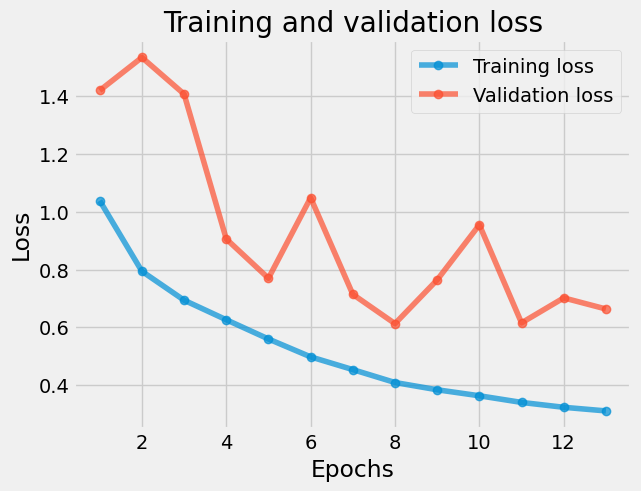

In [47]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, label='Training loss', marker='o', alpha=0.7)
plt.plot(epochs, val_loss, label='Validation loss', marker='o', alpha=0.7)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
X_test_2 = X_test.drop(columns=['qid'])
X_test_arr = X_test_2.values.astype(int)
y_test_array = y_test.values.ravel()

test_loss = model.evaluate(X_test_arr, y_test_array)

1308/1308 [==============================] - 3s 2ms/step - loss: 0.5826


In [43]:
predictions = model.predict(X_test_arr.astype(float))

predictions = predictions.reshape(-1)

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': predictions})
y_test_df.head()

1308/1308 [==============================] - 2s 2ms/step


,relevance_score,predicted_ranking
0,1,1.807713
1,0,2.166996
2,0,2.018651
3,0,0.380431
4,0,1.685409


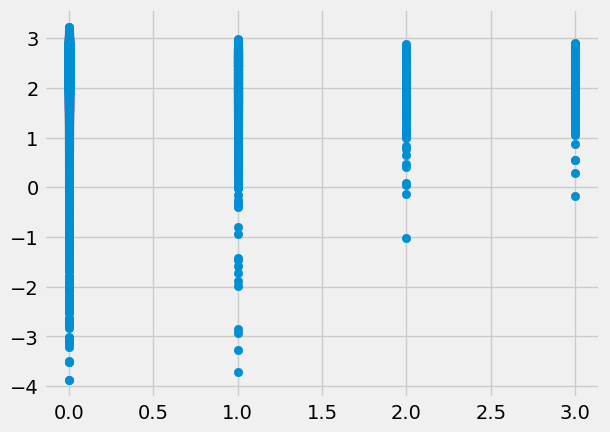

In [44]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()